## Problem statement
##### Predict the burned area of the forest using Neural networks
### Importing the libraries


In [1]:
from sklearn.model_selection import GridSearchCV, KFold,train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import tensorflow.keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sn
from sklearn import preprocessing

### Loading the dataset


In [2]:
forest = pd.read_csv("forestfires.csv")
forest.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


##### We can just peek into few data points by using head function of pandas. By default, head function return top 5 values
### Data Insights

In [3]:
forest.shape

(517, 31)

In [4]:
forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

### Observations :-
##### We could see there are no null values and there are few categorical columns and few numerical (continuous) columns month month of the year: 'jan' to 'dec' day day of the week: 'mon' to 'sun' FFMC FFMC index from the FWI system: 18.7 to 96.20 DMC DMC index from the FWI system: 1.1 to 291.3 DC DC index from the FWI system: 7.9 to 860.6 ISI ISI index from the FWI system: 0.0 to 56.10 temp temperature in Celsius degrees: 2.2 to 33.30 RH relative humidity in %: 15.0 to 100 wind wind speed in km/h: 0.40 to 9.40 rain outside rain in mm/m2 : 0.0 to 6.4 Size_Categorie the burned area of the forest ( Small , Large)


In [5]:
dups = forest.duplicated()
print('Number of duplicate rows: %d' % dups.sum())

Number of duplicate rows: 8


#### There are 8 duplicate rows, we will delete the duplicate rows.

In [6]:
print('Number of rows before discarding duplicates = %d' % forest.shape[0])

forest = forest.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % forest.shape[0])

Number of rows before discarding duplicates = 517
Number of rows after discarding duplicates = 509


##### We will drop the month and day columns from the dataframe as it already encoded with dummy encoding and converted to 0 and 1


In [7]:
forest = forest.drop(['month','day'],axis=1)
forest.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,1,0,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,1,0,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,small


### Summary statistics

In [8]:
forest.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
count,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,...,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000
mean,90.618075,110.235756,547.787623,9.023576,18.865422,44.253438,4.011395,0.020432,12.992908,0.163065,...,0.017682,0.039293,0.003929,0.062868,0.031434,0.104126,0.003929,0.001965,0.029470,0.337917
std,5.555527,63.804112,248.196222,4.585083,5.841083,16.365192,1.800926,0.296261,64.133357,0.369788,...,0.131921,0.194482,0.062622,0.242965,0.174660,0.305724,0.062622,0.044324,0.169285,0.473466
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.200000,62.300000,437.700000,6.400000,15.400000,32.000000,2.700000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.610000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.900000,141.300000,713.900000,11.000000,22.800000,53.000000,4.900000,0.000000,6.580000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Understanding the target variable
##### Our main objective is to classify the burned area of forest based on the given parameters. We have a column size_category which has the values small and large (burned forest area)
##### value_counts() method shows how many samples are present for size_category type.


In [9]:
forest['size_category'].value_counts()

small    371
large    138
Name: size_category, dtype: int64

In [10]:
forest.loc[forest["size_category"]=='small','size_category']=0
forest.loc[forest["size_category"]=='large','size_category']=1
forest["size_category"].value_counts()

0    371
1    138
Name: size_category, dtype: int64

##### We have converted the small size category as 0 and large size category as 1, as Neural network requires data to be in between 0 to 1
### Data visualization
### Boxplots
##### Boxplots are very intuitive technique to find outliers¶


C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FFMC'>

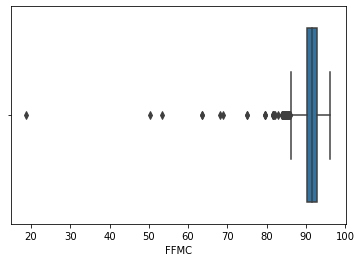

In [11]:
sn.boxplot(forest['FFMC'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DMC'>

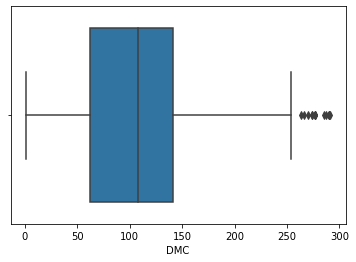

In [12]:
sn.boxplot(forest['DMC'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DC'>

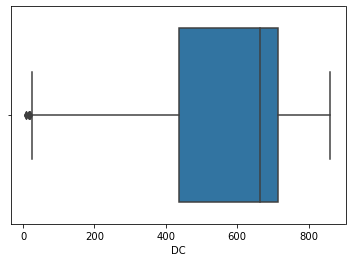

In [13]:
sn.boxplot(forest['DC'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ISI'>

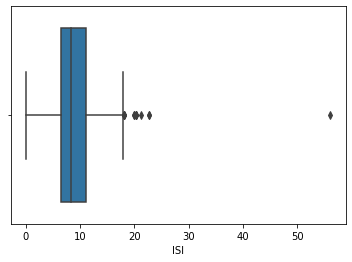

In [14]:
sn.boxplot(forest['ISI'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temp'>

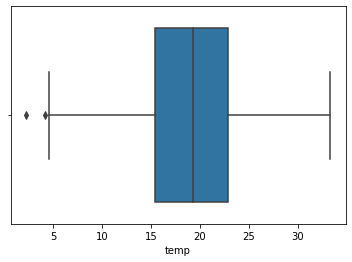

In [15]:
sn.boxplot(forest['temp'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RH'>

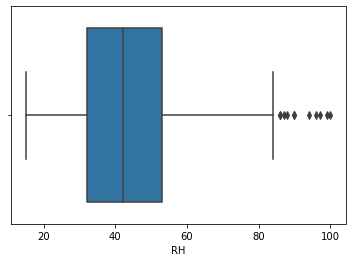

In [16]:
sn.boxplot(forest['RH'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wind'>

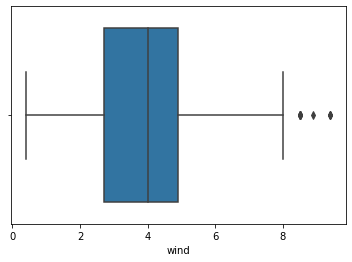

In [17]:
sn.boxplot(forest['wind'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='area'>

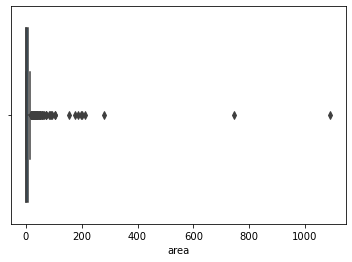

In [18]:
sn.boxplot(forest['area'])

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rain'>

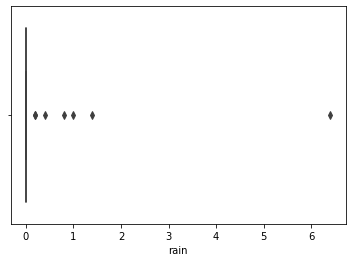

In [19]:
sn.boxplot(forest['rain'])

### Observations :-
##### We could see there are few outliers in our data for all the features.
##### The rain is very less in the given affected areas(almost 0 mm) and the we have few outliers where it is more than 5 mm
### Heatmap
##### Heatmap is a very effective technique to check the missing values in the dataset and to also understand if there is any correlation between the features of the data


<AxesSubplot:>

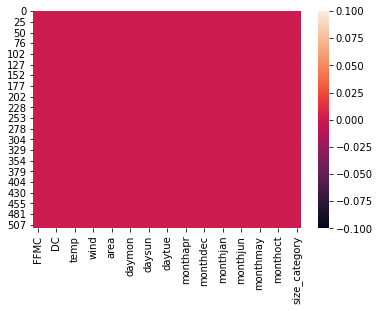

In [20]:
sn.heatmap(forest.isnull())

##### We don't have any missing values in our dataset. If it was present, there would be a different colour shade appearing on the red background.
### Separating feature data and Label data and train-test split


In [21]:
forest.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,1,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,1,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
X = forest.drop(["size_category"], axis = 1)
           
Y = forest['size_category']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 30)

In [23]:
X_train

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
12,63.5,70.8,665.3,0.8,17.0,72,6.7,0.0,0.00,1,...,0,0,0,0,0,0,0,0,0,0
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,0,...,0,0,0,1,0,0,0,0,0,0
214,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,0,...,0,0,0,0,0,1,0,0,0,0
509,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,1,...,0,0,0,0,0,0,0,0,0,0
305,89.6,84.1,714.3,5.7,19.0,52,2.2,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,1
434,90.6,269.8,811.2,5.5,22.2,45,3.6,0.0,0.00,1,...,0,0,0,0,0,0,0,0,0,0
425,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
Y_train

513    1
12     0
138    0
214    1
509    0
      ..
507    0
305    0
434    0
425    0
296    0
Name: size_category, Length: 356, dtype: object

In [25]:
Y_train = np.array(Y_train)

In [26]:
X_test

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
355,92.1,99.0,745.3,9.6,20.8,35,4.9,0.0,13.06,1,...,0,0,0,0,0,0,0,0,0,1
360,92.5,122.0,789.7,10.2,18.4,42,2.2,0.0,1.09,1,...,0,0,0,0,0,0,0,0,0,1
314,92.6,115.4,777.1,8.8,19.7,41,1.8,0.0,1.58,0,...,0,0,0,0,0,0,0,0,0,1
363,91.9,111.7,770.3,6.5,15.9,53,2.2,0.0,2.93,0,...,0,0,0,0,0,0,0,0,0,1
135,93.5,139.4,594.2,20.3,17.6,52,5.8,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,88.6,69.7,706.8,5.8,20.6,37,1.8,0.0,0.00,1,...,0,0,0,0,0,0,0,0,0,1
245,91.8,175.1,700.7,13.8,26.8,38,6.3,0.0,0.76,0,...,0,0,0,0,0,0,0,0,0,0
194,94.8,108.3,647.1,17.0,24.6,22,4.5,0.0,10.01,0,...,0,0,0,0,0,0,0,0,0,0
185,91.0,129.5,692.6,7.0,17.6,46,3.1,0.0,7.04,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
Y_test

355    1
360    0
314    0
363    0
135    0
      ..
32     0
245    0
194    1
185    1
277    1
Name: size_category, Length: 153, dtype: object

In [28]:
Y_test = np.array(Y_test)

### Normalizing our data to make it consistent and scale-free

In [29]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [30]:
X_train_norm.shape

(356, 28)

In [31]:
X_test_norm.shape

(153, 28)

In [32]:
Y_train.shape

(356,)

In [33]:
Y_test.shape

(153,)

### Using Neural network for prediction
##### As Neural network requires a lot of hyperparameters and if we use GridSearch for all of them to find the best parameters , it will take lot of time. So we will use 2 hyperparameters at once for finding the best parameters using GridSearchCV
#### Tuning of Hyperparameters :- Batch Size and Epochs


In [34]:
# create model
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=28, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [40]:
model = tensorflow.keras(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,200,400,450]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_train_norm,Y_train)

TypeError: 'module' object is not callable

In [36]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

NameError: name 'grid_result' is not defined

In [37]:
from keras.layers import Dropout

# Defining the model

def create_model(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(8,input_dim = 28,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4,input_dim = 28,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 20,epochs = 450)

# Define the grid search parameters

learning_rate = [0.0001,0.001,0.01,0.1]
dropout_rate = [0.0,0.05,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_train_norm,Y_train)

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'